# 1. 데이터 불러오기

In [1]:
# uv add yfinance 
import yfinance as yf 
from datetime import date, timedelta 

year = 5
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = today - timedelta(days=365*year)

print(start_date, end_date)

data = yf.download(
    tickers = "009450.KS",
    start = start_date,
    end = end_date
)
data.head()

2020-09-10 2025-09-09


C:\Users\user\AppData\Local\Temp\ipykernel_28584\4076130856.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,009450.KS,009450.KS,009450.KS,009450.KS,009450.KS
Date,,,,,
2020-09-10,57102.957031,58816.045742,55009.181940,55389.868320,384979
2020-09-11,57293.300781,58054.673549,55389.868862,56531.928013,153445
2020-09-14,55865.730469,57293.304501,55580.215662,57293.304501,125104
2020-09-15,56246.414062,56531.928855,54438.153712,55865.727673,107441
2020-09-16,55865.730469,58530.535329,54533.328038,56246.416877,234832


In [2]:
# 멀티컬럼 제거하기 
data.columns = data.columns.droplevel(1)
data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-09-10,57102.957031,58816.045742,55009.181940,55389.868320,384979
2020-09-11,57293.300781,58054.673549,55389.868862,56531.928013,153445
2020-09-14,55865.730469,57293.304501,55580.215662,57293.304501,125104
2020-09-15,56246.414062,56531.928855,54438.153712,55865.727673,107441
2020-09-16,55865.730469,58530.535329,54533.328038,56246.416877,234832


In [3]:
data = data[["Close"]]
data.head()

Price,Close
Date,
2020-09-10,57102.957031
2020-09-11,57293.300781
2020-09-14,55865.730469
2020-09-15,56246.414062
2020-09-16,55865.730469


In [4]:
# scikit-learn pandas matplotlib 
# CUDA를 사용하기 위한 torch 설치 *

In [5]:
import torch
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.8.0+cu126
cuda


# 2. 데이터 분할

In [6]:
N = len(data)
test_ratio = 0.2 
val_ratio = 0.1

test_size = int(N * test_ratio)
val_size = int(N * val_ratio)
train_size = N - val_size - test_size

# 시계열 데이터는 데이터 사이의 순서가 있으므로 다음과 같이 분할한다
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:(train_size+val_size)]
test_data = data.iloc[(train_size+val_size):]

print(f"Train Data: {train_data.shape}, Val Data: {val_data.shape}, Test Data: {test_data.shape}")

Train Data: (857, 1), Val Data: (122, 1), Test Data: (244, 1)


# 3. 데이터 스케일러 적용

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_a = pd.DataFrame([50, 100, 150]) # 예상 결과 0, 0.5, 1
data_b = pd.DataFrame([0, 50, 100, 150, 200]) # 예상 결과 -0.5, 0, 0.5, 1, 1.5
scaler_a = scaler.fit_transform(data_a.values)
scaler_b = scaler.transform(data_b.values)
print(scaler_a)
print(scaler_b)

[[0. ]
 [0.5]
 [1. ]]
[[-0.5]
 [ 0. ]
 [ 0.5]
 [ 1. ]
 [ 1.5]]


In [8]:
from sklearn.preprocessing import MinMaxScaler
# 질문1. MinMaxScaler는 무엇일까?  : 각 값간의 거리 비율을 유지한 상태에서 최대 최소 값을 1 0 으로 축소한다
# 질문2. 스케일러를 사용할 때 반드시 주의해야할 점은 무엇일까? : val, test 데이터는 스케일러에 포함하지 말 것

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values) # train의 스케일링 기준울 기억 이후 val, test 로 평가할 떄 사용
val_scaled = scaler.transform(val_data.values)      
test_scaled = scaler.transform(test_data.values)    

print(f"train_scaled: {train_scaled.dtype}")
print(f"val_scaled: {val_scaled.dtype}")
print(f"test_scaled: {test_scaled.dtype}")

print(f"Scale 범위: {scaler.data_min_}, {scaler.data_max_}")

train_scaled: float64
val_scaled: float64
test_scaled: float64
Scale 범위: [32080.44335938], [74072.03125]


# 4. 학습 데이터

In [9]:
print(train_scaled.shape)

(857, 1)


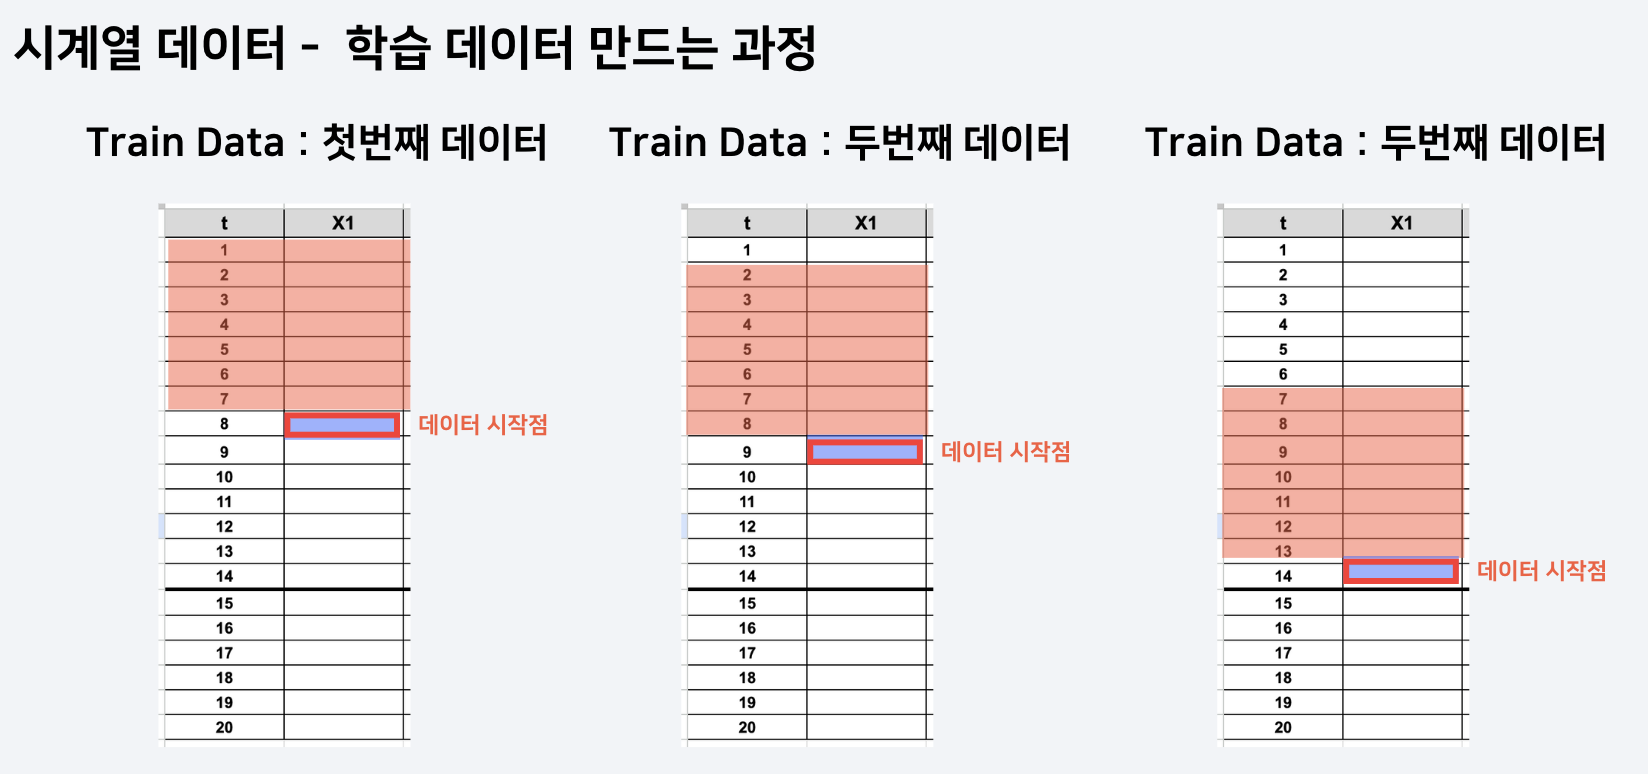

In [10]:
import numpy as np 
# 질문 1. Window가 무엇을 의미하는지 설명할 수 있다. 
# 질문 2. train data가 몇 개 나오는지 설명할 수 있다. > 전체 데이터 - 윈도우 사이즈
def make_dataset(data, window):
    dataX = []
    datay = []

    for i in range(0, data.shape[0] - window):
        x = data[i:(i + window), :]
        y = data[(i + window), [-1]]
        
        dataX.append(x)
        datay.append(y)
    
    return np.array(dataX), np.array(datay)

window = 60
X_train, y_train = make_dataset(train_scaled, window)
# val_scaled의 X, y를 만들기 위해서는 train_scaled에서 맨 뒤에서 window만큼 가져와야 한다. 
X_val, y_val = make_dataset(np.concatenate([train_scaled[-window:], val_scaled]), window)
X_test, y_test = make_dataset(np.concatenate([val_scaled[-window:], test_scaled]), window)

print(X_train.shape, y_train.shape)
print(val_scaled.shape, X_val.shape, y_val.shape)
print(test_scaled.shape, X_test.shape, y_test.shape)

(797, 60, 1) (797, 1)
(122, 1) (122, 60, 1) (122, 1)
(244, 1) (244, 60, 1) (244, 1)


In [11]:
import numpy as np

a = np.array([[1, 2], [3, 4]])
b = np.array([[7, 8], [9, 10], [11, 12]])

print(np.concatenate((a, b), axis=0))

[[ 1  2]
 [ 3  4]
 [ 7  8]
 [ 9 10]
 [11 12]]


In [12]:
import numpy as np
test_data = np.array([[1.0, 2.0]])
print(test_data[0])
print(test_data[0, [-1]])

[1. 2.]
[2.]


# 5. DataLoader 만들기

In [13]:
import torch

X_train_ts = torch.FloatTensor(X_train)
y_train_ts = torch.FloatTensor(y_train)
X_val_ts = torch.FloatTensor(X_val)
y_val_ts = torch.FloatTensor(y_val)
X_test_ts = torch.FloatTensor(X_test)
y_test_ts = torch.FloatTensor(X_test)

In [14]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_ts, y_train_ts)
val_dataset = TensorDataset(X_val_ts, y_val_ts)
test_dataset = TensorDataset(X_test_ts, y_test_ts)

print(len(train_dataset))
print(train_dataset[0])

797
(tensor([[0.5959],
        [0.6004],
        [0.5664],
        [0.5755],
        [0.5664],
        [0.5143],
        [0.5166],
        [0.4758],
        [0.4576],
        [0.4735],
        [0.4372],
        [0.3806],
        [0.4395],
        [0.4304],
        [0.4848],
        [0.4916],
        [0.4848],
        [0.5120],
        [0.5188],
        [0.5188],
        [0.4871],
        [0.4780],
        [0.4576],
        [0.4599],
        [0.4667],
        [0.4894],
        [0.4667],
        [0.4644],
        [0.4146],
        [0.4214],
        [0.4395],
        [0.4372],
        [0.4372],
        [0.4440],
        [0.4440],
        [0.4327],
        [0.4418],
        [0.4599],
        [0.5007],
        [0.5664],
        [0.5279],
        [0.4894],
        [0.4894],
        [0.4871],
        [0.4667],
        [0.4690],
        [0.4871],
        [0.4871],
        [0.4780],
        [0.4939],
        [0.4984],
        [0.4690],
        [0.4531],
        [0.4418],
        [0.4486],
     

In [15]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# 6. 모델 만들기

In [16]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first = True,
            dropout = dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(in_features = hidden_size, out_features = 1)
    
    def forward(self, x):
        # out : 모든 시점의 요약
        # hn : 마지막 시점의 Hidden State
        # cn : 마지막 시점의 Cell State
        out, (hn, cn) = self.lstm(x)
        pred = self.fc(hn[-1])
        return pred

In [17]:
model = LSTMRegressor(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    dropout=0.2
)

# 7. 학습하기

In [18]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

In [19]:
import torch.nn as nn
from torch.optim.adam import Adam
import tqdm

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

model = model.to(device)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
epoches = 20
criterion = nn.MSELoss()

best_val_loss = float("inf")
patience = 0
loss_history = []

step = 0

# 학습 
for epoch in range(epoches):
    # Train
    model.train()

    train_loss_history = []
    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        optim.zero_grad()

        y_pred = model(data)

        loss = criterion(y_pred, label)
        loss.backward()

        optim.step()

        train_loss_history.append(loss.item())

    # Validation 
    model.eval()

    val_loss_history = []
    with torch.no_grad():
        for data, label in tqdm.tqdm(val_dataloader):
            data = data.to(device)
            label = label.to(device)

            y_pred = model(data)
            loss = criterion(y_pred, label)
            val_loss_history.append(loss.item())
    
    # 출력
    train_loss = float(np.mean(train_loss_history))
    val_loss = float(np.mean(val_loss_history))

    loss_history.append(train_loss)
    print(f"EPOCH {epoch} : train_loss = {train_loss:.4f} val_loss = {val_loss}")
    writer.add_scalar("Loss/train", train_loss, step)
    writer.add_scalar("Loss/val", val_loss, step)
    step += 1
    
    # 학습 끝내는 조건
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), "./models/best_model.pth")
    else:
        patience += 1
        if patience >= 5:
            break

# 학습 저장
torch.save(model.state_dict(), "./models/last.pt")

100%|██████████| 3/3 [00:00<00:00, 164.53it/s]


EPOCH 0 : train_loss = 0.1353 val_loss = 0.15341269969940186


100%|██████████| 3/3 [00:00<00:00, 583.38it/s]


EPOCH 1 : train_loss = 0.0689 val_loss = 0.07777345987657706


100%|██████████| 3/3 [00:00<00:00, 600.13it/s]


EPOCH 2 : train_loss = 0.0528 val_loss = 0.08512668559948604


100%|██████████| 3/3 [00:00<00:00, 750.01it/s]


EPOCH 3 : train_loss = 0.0405 val_loss = 0.017210179784645636


100%|██████████| 3/3 [00:00<00:00, 546.18it/s]


EPOCH 4 : train_loss = 0.0178 val_loss = 0.10976413637399673


100%|██████████| 3/3 [00:00<00:00, 581.28it/s]

EPOCH 5 : train_loss = 0.0434 val_loss = 0.02060620579868555



100%|██████████| 3/3 [00:00<00:00, 555.32it/s]


EPOCH 6 : train_loss = 0.0143 val_loss = 0.02356636120627324


100%|██████████| 3/3 [00:00<00:00, 599.56it/s]


EPOCH 7 : train_loss = 0.0065 val_loss = 0.010389410502587756


100%|██████████| 3/3 [00:00<00:00, 720.46it/s]


EPOCH 8 : train_loss = 0.0081 val_loss = 0.013853853413214287


100%|██████████| 3/3 [00:00<00:00, 490.01it/s]


EPOCH 9 : train_loss = 0.0091 val_loss = 0.02754560423394044


100%|██████████| 3/3 [00:00<00:00, 727.97it/s]


EPOCH 10 : train_loss = 0.0093 val_loss = 0.008425821705410877


100%|██████████| 3/3 [00:00<00:00, 750.28it/s]


EPOCH 11 : train_loss = 0.0046 val_loss = 0.008486250958715877


100%|██████████| 3/3 [00:00<00:00, 727.71it/s]


EPOCH 12 : train_loss = 0.0051 val_loss = 0.027036816192169983


100%|██████████| 3/3 [00:00<00:00, 725.07it/s]


EPOCH 13 : train_loss = 0.0087 val_loss = 0.008443245897069573


100%|██████████| 3/3 [00:00<00:00, 731.18it/s]


EPOCH 14 : train_loss = 0.0030 val_loss = 0.0083555708018442


100%|██████████| 3/3 [00:00<00:00, 750.77it/s]


EPOCH 15 : train_loss = 0.0051 val_loss = 0.025303081298867863


100%|██████████| 3/3 [00:00<00:00, 750.28it/s]


EPOCH 16 : train_loss = 0.0088 val_loss = 0.010477307951077819


100%|██████████| 3/3 [00:00<00:00, 723.99it/s]


EPOCH 17 : train_loss = 0.0031 val_loss = 0.009850293165072799


100%|██████████| 3/3 [00:00<00:00, 723.49it/s]


EPOCH 18 : train_loss = 0.0056 val_loss = 0.01800022041425109


100%|██████████| 3/3 [00:00<00:00, 583.87it/s]

EPOCH 19 : train_loss = 0.0074 val_loss = 0.014254888830085596


Text(0, 0.5, 'loss')

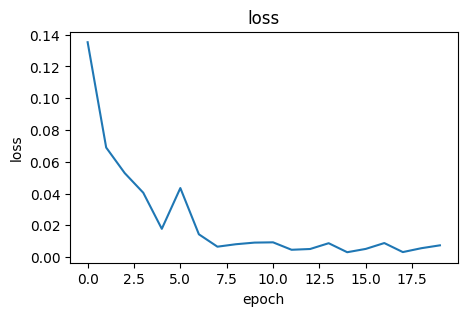

In [20]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(5,3))
plt.plot(loss_history)
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")

# 8. 평가하기

In [21]:
# Validation 
model.eval()

test_loss_history = []
with torch.no_grad():
    for data, label in test_dataloader:
        data = data.to(device)
        label = label.to(device)
        label = np.squeeze(label, axis=2)

        pred = model(data)
        loss = criterion(pred, label)
        test_loss_history.append(loss.item())

print(float(np.mean(test_loss_history)))

0.06366269513964654


c:\Potenup\DeepLearning-LLM-Study\.venv\Lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([50, 60])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Potenup\DeepLearning-LLM-Study\.venv\Lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([44, 60])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [22]:
X_test_ts = torch.FloatTensor(X_test)
y_test_ts = torch.FloatTensor(y_test)

# 예측값 저장
pred_history = []
for i in range(len(X_test_ts)):
    with torch.no_grad():
        data = X_test_ts[i].to(device)
        pred = model(data.unsqueeze(dim=0))
        print(pred.item())
        pred_history.append(pred.item())

0.7795664072036743
0.7647687196731567
0.7418975830078125
0.7249451279640198
0.7150919437408447
0.7116766571998596
0.7148334980010986
0.7215568423271179
0.7324337363243103
0.7445034980773926
0.7563294768333435
0.7702205181121826
0.7805173993110657
0.7828635573387146
0.7880908846855164
0.7983523011207581
0.8050593733787537
0.8113585114479065
0.8149589896202087
0.8153254389762878
0.8150666356086731
0.8306190371513367
0.8587403297424316
0.8893436193466187
0.9323377013206482
0.9827751517295837
1.034257173538208
1.0740067958831787
1.104001760482788
1.1213665008544922
1.1452094316482544
1.1633156538009644
1.1757663488388062
1.1753870248794556
1.1689592599868774
1.1568306684494019
1.1496151685714722
1.144405722618103
1.1416821479797363
1.1358858346939087
1.1376713514328003
1.140272617340088
1.1373428106307983
1.1377670764923096
1.1520096063613892
1.1579420566558838
1.1692792177200317
1.179276704788208
1.1727674007415771
1.1545392274856567
1.13827383518219
1.1175459623336792
1.0908721685409546


In [23]:
# Scaler 되돌리기 
pred_inverse = scaler.inverse_transform(np.array(pred_history).reshape(-1,1))
# print(np.array(pred_history))
# print(np.array(pred_history).reshape(-1,1))
# print(pred_inverse)

y_test_inverse = scaler.inverse_transform(y_test_ts)

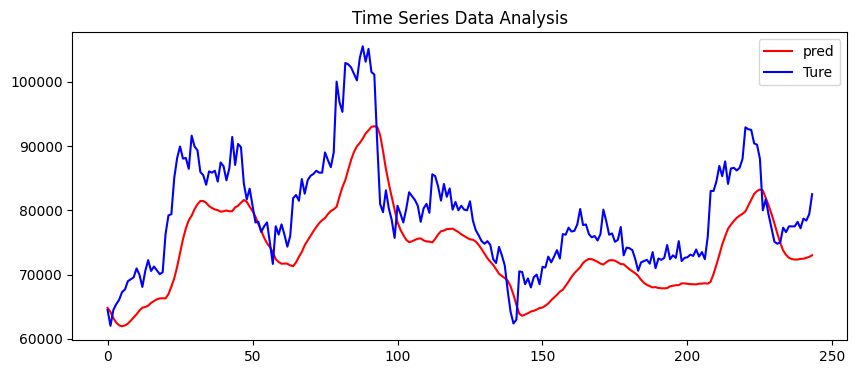

In [24]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label="pred", color="r")
plt.plot(np.arange(len(y_test_inverse)), y_test_inverse, label="Ture", color="b")
plt.legend()
plt.title("Time Series Data Analysis")
plt.show()